# Analysis of alternative pathway scenarios

## Aims: 

Analyse the performance of the following scenarios:

1) Base: Uses the hospitals' recorded pathway statistics in SSNAP (same as validation notebook)

2) Speed: Sets 95% of patients having a scan within 4 hours of arrival, and all patients have 15 minutes arrival to scan and 15 minutes scan to needle.

3) Onset-known: Sets the proportion of patients with a known onset time of stroke to the national upper quartile if currently less than the national upper quartile (leave any greater than the upper national quartile at their current level).

4) Benchmark: The benchmark thrombolysis rate takes the likelihood to give thrombolysis for patients scanned within 4 hours of onset from the majority vote of the 30 hospitals with the highest predicted thrombolysis use in a standard 10k cohort set of patients. These are from Random Forests models.

5) Combine *Speed* and *Onset-known*

6) Combine *Speed* and *Benchmark*

7) Combine *Onset-known* and *Benchmark*

8) Combine *Speed*, *Onset-known* and *Benchmark*

The analysis will be at a global level (all hospitals together) as well as demonstrating analysis at a hospital level.


## Load libraries

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

## Load data

In [2]:
# Scenario results
results = pd.read_csv('./output/scenario_results.csv')
# Pathway performance paramters used in scenarios
performance_base = pd.read_csv('./output/performance_base.csv')
performance_speed = pd.read_csv('./output/performance_speed.csv')
performance_onset = pd.read_csv('./output/performance_onset.csv')
performance_speed_onset = pd.read_csv('./output/performance_speed_onset.csv')
performance_speed_benchmark = \
    pd.read_csv('./output/performance_speed_benchmark.csv')
performance_onset_benchmark = \
    pd.read_csv('./output/performance_onset_benchmark.csv')
performance_speed_onset_benchmark = \
    pd.read_csv('./output/performance_speed_onset_benchmark.csv')
performance_same_patients = \
    pd.read_csv('./output/same_patient_characteristics.csv')

In [3]:
performance_base

,stroke_team,thrombolysis_rate,admissions,80_plus,onset_known,known_arrival_within_4hrs,onset_arrival_mins_mu,onset_arrival_mins_sigma,scan_within_4_hrs,arrival_scan_arrival_mins_mu,arrival_scan_arrival_mins_sigma,onset_scan_4_hrs,eligable,scan_needle_mins_mu,scan_needle_mins_sigma
0,AGNOF1041H,0.154839,671.666667,0.425459,0.635236,0.681250,4.576874,0.557598,0.965596,1.665700,1.497966,0.935867,0.388325,3.669602,0.664462
1,AKCGO9726K,0.158892,1143.333333,0.395658,0.970845,0.428829,4.625486,0.597451,0.955882,2.834183,0.999719,0.908425,0.419355,2.904479,0.874818
2,AOBTM3098N,0.085885,500.666667,0.485470,0.619174,0.629032,4.603918,0.584882,0.935043,3.471419,1.254744,0.846435,0.267819,3.694918,0.518929
3,APXEE8191H,0.098634,439.333333,0.515679,0.716237,0.608051,4.590357,0.496452,0.966899,3.312930,0.714465,0.904505,0.258964,3.585094,0.751204
4,ATDID5461S,0.090689,275.666667,0.533546,0.573156,0.660338,4.427826,0.591373,0.878594,4.125690,0.549301,0.865455,0.315126,3.497262,0.608126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,YPKYH1768F,0.105193,250.333333,0.321767,0.585885,0.720455,4.436404,0.569248,0.952681,3.779215,0.872809,0.844371,0.305882,3.982100,0.683223
128,YQMZV4284N,0.104186,358.333333,0.508511,0.945116,0.462598,4.664536,0.494740,0.948936,3.574735,0.912298,0.798206,0.308989,3.285165,0.463749
129,ZBVSO0975W,0.081602,449.333333,0.442130,0.465134,0.688995,4.562051,0.510524,0.972222,2.860226,0.990966,0.930952,0.273657,3.606046,0.575788
130,ZHCLE1578P,0.112647,796.000000,0.484694,0.733668,0.671233,4.606557,0.546648,0.949830,3.306916,0.842940,0.892569,0.262788,3.276043,0.795401


## Collate key results

Collate key results together in a DataFrame.

In [4]:
# Add admission numbers to results
admissions = performance_base[['stroke_team', 'admissions']]
results = results.merge(
    admissions, how='left', left_on='stroke_team', right_on='stroke_team')

# Calculate numbers thrombolysed
results['thrombolysed'] = \
    results['admissions'] * results['Percent_Thrombolysis_(mean)'] / 100

# Calculate additional good outcomes
results['add_good_outcomes'] = (results['admissions'] * 
    results['Additional_good_outcomes_per_1000_patients_(mean)'] / 1000)

# Get key results
key_results = pd.DataFrame()
key_results['stroke_team'] = results['stroke_team']
key_results['scenario'] = results['scenario']
key_results['admissions'] = results['admissions']
key_results['thrombolysis_rate'] = results['Percent_Thrombolysis_(mean)']
key_results['additional_good_outcomes_per_1000_patients'] = \
    results['Additional_good_outcomes_per_1000_patients_(mean)']
key_results['patients_receiving_thrombolysis'] = results['thrombolysed']
key_results['add_good_outcomes'] = results['add_good_outcomes']

In [5]:
key_results

,stroke_team,scenario,admissions,thrombolysis_rate,additional_good_outcomes_per_1000_patients,patients_receiving_thrombolysis,add_good_outcomes
0,AGNOF1041H,base,671.666667,15.11,12.72,101.488833,8.543600
1,AKCGO9726K,base,1143.333333,15.06,13.43,172.186000,15.354967
2,AOBTM3098N,base,500.666667,7.81,5.74,39.102067,2.873827
3,APXEE8191H,base,439.333333,10.08,7.35,44.284800,3.229100
4,ATDID5461S,base,275.666667,9.20,6.42,25.361333,1.769780
...,...,...,...,...,...,...,...
1183,YPKYH1768F,same_patient_characteristics,250.333333,7.40,4.85,18.524667,1.214117
1184,YQMZV4284N,same_patient_characteristics,358.333333,16.47,13.34,59.017500,4.780167
1185,ZBVSO0975W,same_patient_characteristics,449.333333,7.65,6.28,34.374000,2.821813
1186,ZHCLE1578P,same_patient_characteristics,796.000000,10.71,8.70,85.251600,6.925200


In [6]:
key_results.to_csv('./output/key_scenario_results.csv', index=False)

## Overall results

In [7]:
columns = ['admissions', 'patients_receiving_thrombolysis', 'add_good_outcomes']
summary_stats = key_results.groupby('scenario')[columns].sum()
summary_stats['percent_thrombolysis'] = (100 *
    summary_stats['patients_receiving_thrombolysis'] / summary_stats['admissions'])
summary_stats['add_good_outcomes_per_1000'] = (1000 *
    summary_stats['add_good_outcomes'] / summary_stats['admissions'])

In [8]:
# Re-order
order = {'base': 1, 'speed': 2, 'onset': 3, 'benchmark': 4, 'speed_onset': 5,
    'speed_benchmark': 6, 'onset_benchmark':7, 'speed_onset_benchmark': 8,
    'same_patient_characteristics': 9}
df_order = [order[x] for x in list(summary_stats.index)]
summary_stats['order'] = df_order
summary_stats.sort_values('order', inplace=True)

# Select cols of interest
summary_stats = summary_stats[['percent_thrombolysis', 'add_good_outcomes_per_1000']]

base_thrombolysis = summary_stats.loc['base']['percent_thrombolysis']
summary_stats['Percent increase thrombolysis'] = (100 * (
        summary_stats['percent_thrombolysis'] / base_thrombolysis -1))

base_add_good_outcomes = summary_stats.loc['base']['add_good_outcomes_per_1000']
summary_stats['Percent increase good_outcomes'] = (100 * (
    summary_stats['add_good_outcomes_per_1000'] / base_add_good_outcomes -1))

summary_stats = summary_stats.round(2)

summary_stats.to_csv('./output/summary_net_results.csv')

summary_stats

,percent_thrombolysis,add_good_outcomes_per_1000,Percent increase thrombolysis,Percent increase good_outcomes
scenario,,,,
base,11.59,9.40,0.00,0.00
speed,12.36,11.89,6.60,26.42
onset,13.66,11.07,17.88,17.78
benchmark,14.50,11.69,25.10,24.34
speed_onset,14.51,13.97,25.21,48.58
speed_benchmark,15.42,14.81,33.02,57.53
onset_benchmark,17.19,13.87,48.27,47.48
speed_onset_benchmark,18.27,17.56,57.57,86.83
same_patient_characteristics,11.43,9.26,-1.40,-1.52


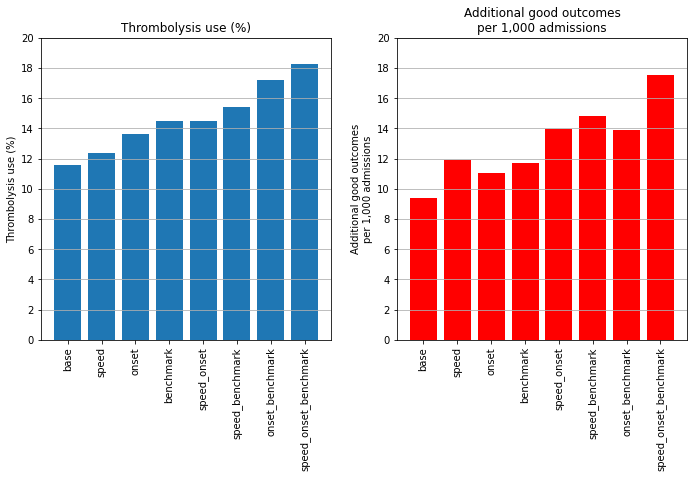

In [24]:
summary_stats_for_fig = summary_stats.drop('same_patient_characteristics')

fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(121)
x = list(summary_stats_for_fig.index)
y1 = summary_stats_for_fig['percent_thrombolysis'].values
ax1.bar(x,y1)
ax1.set_ylim(0,20)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,22,2))
ax1.set_title('Thrombolysis use (%)')
ax1.set_ylabel('Thrombolysis use (%)')
ax1.grid(axis = 'y')

ax2 = fig.add_subplot(122)
x = list(summary_stats_for_fig.index)
y1 = summary_stats_for_fig['add_good_outcomes_per_1000'].values
ax2.bar(x,y1, color='r')
ax2.set_ylim(0,20)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,22,2))
ax2.set_title('Additional good outcomes\nper 1,000 admissions')
ax2.set_ylabel('Additional good outcomes\nper 1,000 admissions')
ax2.grid(axis = 'y')

plt.tight_layout(pad=2)

plt.savefig('./output/global_change.jpg', dpi=300)

plt.show()


### Plot changes at each hospital

In [10]:
def compare_plot(base_rx, test_rx, base_benefit, test_benefit, name):
    
    # Set up sublot
    fig, ax = plt.subplots(1,2, figsize=(10,6))
    
    # Thrombolysis use    
    x = base_rx
    y = test_rx
    for i in range(len(x)):
        if y[i] >= x[i]:
            ax[0].plot([x[i],x[i]],[x[i],y[i]],'g-o', alpha=0.6)
        else:
            ax[0].plot([x[i],x[i]],[x[i],y[i]],'r-o', alpha=0.6)
    ax[0].set_xlim(0)
    ax[0].set_ylim(0)
    ax[0].grid()
    ax[0].set_xlabel('Base thrombolysis use (%)')
    ax[0].set_ylabel('Scenario thrombolysis use (%)')
    ax[0].set_title('Thrombolysis use')
    
    # Benefit
    x = base_benefit
    y = test_benefit
    for i in range(len(x)):
        if y[i] >= x[i]:
            ax[1].plot([x[i],x[i]],[x[i],y[i]],'g-o', alpha=0.6)
        else:
            ax[1].plot([x[i],x[i]],[x[i],y[i]],'r-o', alpha=0.6)
    ax[1].set_xlim(0)
    ax[1].set_ylim(0)
    ax[1].grid()
    ax[1].set_xlabel('Base benefit')
    ax[1].set_ylabel(f'Scenario benefit')
    ax[1].set_title('Clinical benefit\n(additional good outcomes for 1,000 admissions)')
    
    
    # Make axes places consistent
    ax[0].xaxis.set_major_locator(MultipleLocator(5))
    ax[0].yaxis.set_major_locator(MultipleLocator(5))
    ax[1].xaxis.set_major_locator(MultipleLocator(5))
    ax[1].yaxis.set_major_locator(MultipleLocator(5))
    ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    fig.tight_layout(pad=2)
    plt.savefig(f'{name}.jpg', dpi=300)

#### Plot effect of speed

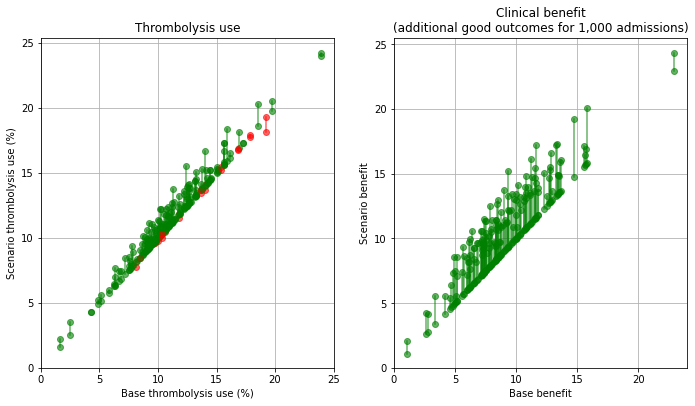

In [11]:
base_rx = key_results[key_results['scenario'] == 'base']['thrombolysis_rate'].values
scenario_rx = key_results[key_results['scenario'] == 'speed']['thrombolysis_rate'].values
base_benfit = key_results[key_results['scenario'] == 'base']['additional_good_outcomes_per_1000_patients'].values
scenario_benefit = key_results[key_results['scenario'] == 'speed']['additional_good_outcomes_per_1000_patients'].values


compare_plot(base_rx, scenario_rx, base_benfit, scenario_benefit,
                     './output/hospitals_speed')

#### Plot effect of onset-known

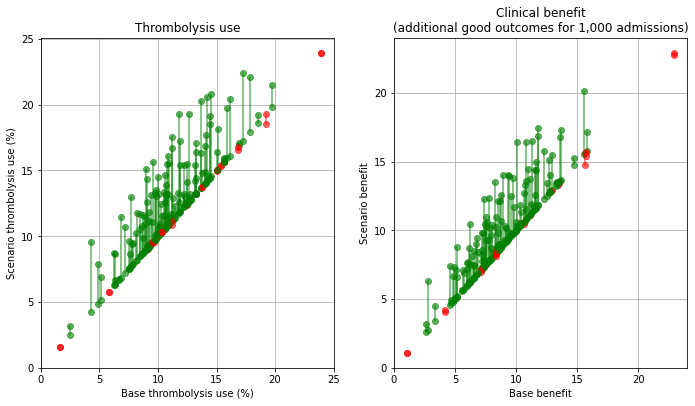

In [12]:
base_rx = key_results[key_results['scenario'] == 'base']['thrombolysis_rate'].values
scenario_rx = key_results[key_results['scenario'] == 'onset']['thrombolysis_rate'].values
base_benfit = key_results[key_results['scenario'] == 'base']['additional_good_outcomes_per_1000_patients'].values
scenario_benefit = key_results[key_results['scenario'] == 'onset']['additional_good_outcomes_per_1000_patients'].values


compare_plot(base_rx, scenario_rx, base_benfit, scenario_benefit,
                     './output/hospitals_onset')

#### Plot effect of benchmark decisions

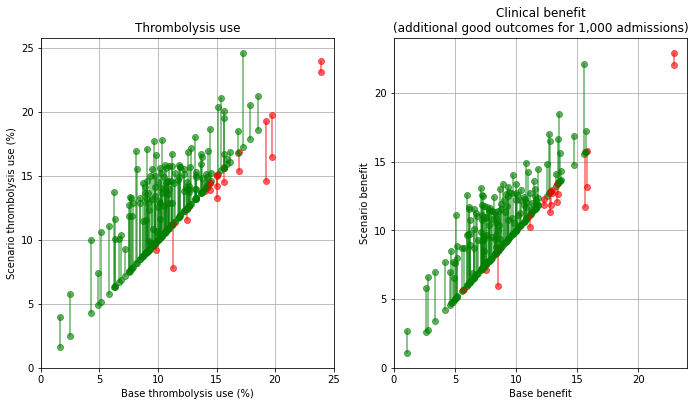

In [13]:
base_rx = key_results[key_results['scenario'] == 'base']['thrombolysis_rate'].values
scenario_rx = key_results[key_results['scenario'] == 'benchmark']['thrombolysis_rate'].values
base_benfit = key_results[key_results['scenario'] == 'base']['additional_good_outcomes_per_1000_patients'].values
scenario_benefit = key_results[key_results['scenario'] == 'benchmark']['additional_good_outcomes_per_1000_patients'].values


compare_plot(base_rx, scenario_rx, base_benfit, scenario_benefit,
                     './output/hospitals_benchmark')

#### Plot effect of all changes

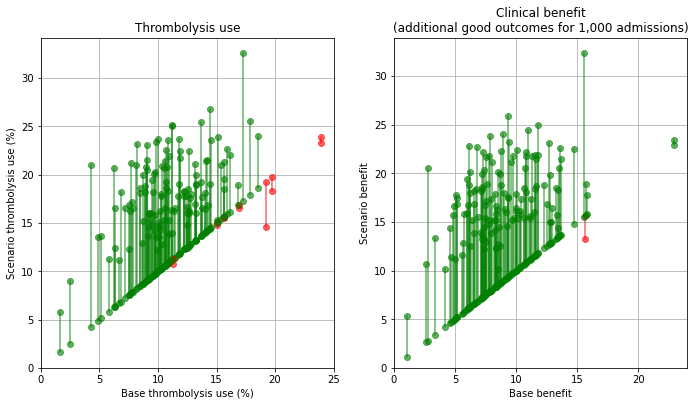

In [14]:
base_rx = key_results[key_results['scenario'] == 'base']['thrombolysis_rate'].values
scenario_rx = key_results[key_results['scenario'] == 'speed_onset_benchmark']['thrombolysis_rate'].values
base_benfit = key_results[key_results['scenario'] == 'base']['additional_good_outcomes_per_1000_patients'].values
scenario_benefit = key_results[key_results['scenario'] == 'speed_onset_benchmark']['additional_good_outcomes_per_1000_patients'].values


compare_plot(base_rx, scenario_rx, base_benfit, scenario_benefit,
                     './output/hospitals_speed_onset_benchmark')

### Histogram of shift in distribution of thrombolysis use and benefit

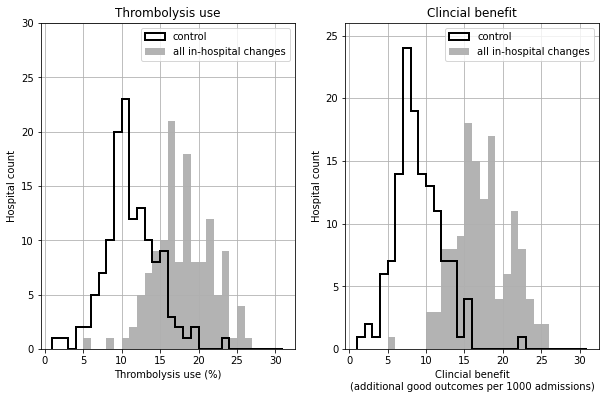

In [15]:
base_rx = key_results[key_results['scenario'] == 'base']['thrombolysis_rate'].values
scenario_rx = key_results[key_results['scenario'] == 'speed_onset_benchmark']['thrombolysis_rate'].values
base_benfit = key_results[key_results['scenario'] == 'base']['additional_good_outcomes_per_1000_patients'].values
scenario_benefit = key_results[key_results['scenario'] == 'speed_onset_benchmark']['additional_good_outcomes_per_1000_patients'].values


fig, ax = plt.subplots(1,2,figsize=(10,6))
bins = np.arange(1,32)
ax[0].hist(base_rx, bins = bins, color='k', linewidth=2,
           label='control', histtype='step')
ax[0].hist(scenario_rx, bins = bins, color='0.7', linewidth=2,
           label='all in-hospital changes', histtype='stepfilled')
ax[0].grid()
ax[0].set_xlabel('Thrombolysis use (%)')
ax[0].set_ylabel('Hospital count')
ax[0].set_ylim(0,30)
ax[0].yaxis.set_major_locator(MultipleLocator(5))
ax[0].set_title('Thrombolysis use')
ax[0].legend()

ax[1].hist(base_benfit, bins = bins, color='k', linewidth=2,
           label='control', histtype='step')
ax[1].hist(scenario_benefit, bins = bins, color='0.7', linewidth=2,
           label='all in-hospital changes', histtype='stepfilled')
ax[1].grid()
ax[1].set_xlabel('Clincial benefit\n(additional good outcomes per 1000 admissions)')
ax[1].set_ylabel('Hospital count')
ax[1].set_ylim(0,26)
ax[1].yaxis.set_major_locator(MultipleLocator(5))
ax[1].set_title('Clincial benefit')
ax[1].legend()

plt.savefig('./output/histograms.jpg', dpi=300)

### Find which change makes most difference in each hospital

#### Best thrombolysis rate

In [16]:
# Pivot results
results_pivot = (key_results[['thrombolysis_rate', 'scenario', 'stroke_team']].pivot(
    index='stroke_team', columns='scenario'))
results_pivot = results_pivot['thrombolysis_rate']
# Limit to single changes
cols_to_drop = ['speed_benchmark', 'speed_onset', 'onset_benchmark', 'speed_onset_benchmark']
results_pivot.drop(cols_to_drop, axis=1, inplace=True)
# Find largest effect
best_result = results_pivot.idxmax(1)
# Count
best_result.value_counts()

benchmark                       71
onset                           37
same_patient_characteristics    19
speed                            5
dtype: int64

#### Best outcomes

In [17]:
# Pivot results
results_pivot = (key_results[['additional_good_outcomes_per_1000_patients', 
        'scenario', 'stroke_team']].pivot(index='stroke_team', columns='scenario'))
results_pivot = results_pivot['additional_good_outcomes_per_1000_patients']
# Limit to single changes
cols_to_drop = ['speed_benchmark', 'speed_onset', 'onset_benchmark', 'speed_onset_benchmark']
results_pivot.drop(cols_to_drop, axis=1, inplace=True)
# Find largest effect
best_result = results_pivot.idxmax(1)
# Count
best_result.value_counts()

benchmark                       49
speed                           42
onset                           26
same_patient_characteristics    15
dtype: int64

## Bar charts of individual changes at all hospitals

Here we summarise the effect of individual changes at each hospital.

Note that actual combined changes will be more than additive, but these plots give an indication of what the most significant effects will be across all hospitals.

In [18]:
# Pivot results by scenario type
results_pivot = key_results.pivot(index='stroke_team', columns='scenario')

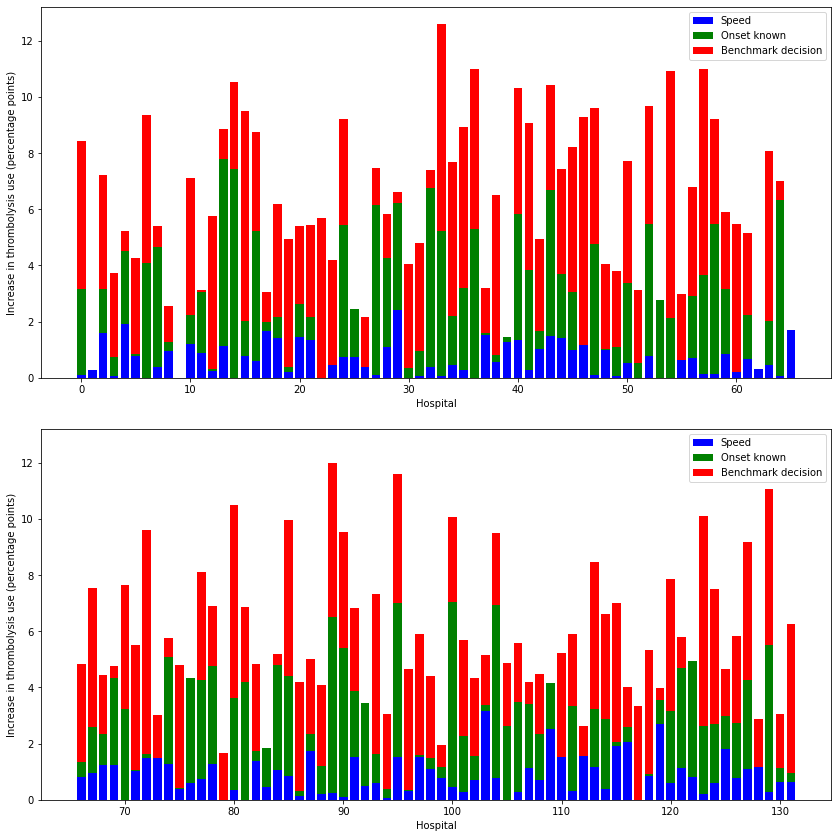

In [19]:
hosp_per_chart = np.ceil(results_pivot.shape[0]/2)

# Thrombolysis chart
fig, axs = plt.subplots(2,1, figsize=(12,12), sharey=True)
# 4 subplots
i=0
for ax in axs.flat:
    # Get subgroup of data for plot
    start = int(hosp_per_chart * i)
    end = int(hosp_per_chart * (i + 1))
    subgroup = results_pivot.iloc[start:end]
    # Get effect of speed (avoid negatives)
    speed = subgroup['thrombolysis_rate']['speed'] - subgroup['thrombolysis_rate']['base']
    speed = list(map (lambda x: max(0,x), speed))
    # Get effect of known onset (avoid negatives)
    onset = subgroup['thrombolysis_rate']['onset'] - subgroup['thrombolysis_rate']['base']
    onset = list(map (lambda x: max(0,x), onset))
    # Get effect of decision (avoid negatives)
    eligible = subgroup['thrombolysis_rate']['benchmark'] - subgroup['thrombolysis_rate']['base']
    eligible = list(map (lambda x: max(0,x), eligible))
    
    x = range(start, start + subgroup.shape[0])
    ax.bar(x, speed, color='b', label = 'Speed')
    ax.bar(x, onset, color='g', bottom = speed, label = 'Onset known')
    ax.bar(x, eligible, color='r', bottom = np.array(speed) + np.array(onset),
           label = 'Benchmark decision')
    ax.legend()
    ax.set_xlabel('Hospital')
    ax.set_ylabel('Increase in thrombolysis use (percentage points)')
    # Put y tick label son all charts
    ax.yaxis.set_tick_params(which='both', labelbottom=True)
    
    i += 1
      
plt.tight_layout(pad=2)
plt.savefig('./output/all_hosp_bar_thrombolysis.jpg', dpi=300)
plt.show()

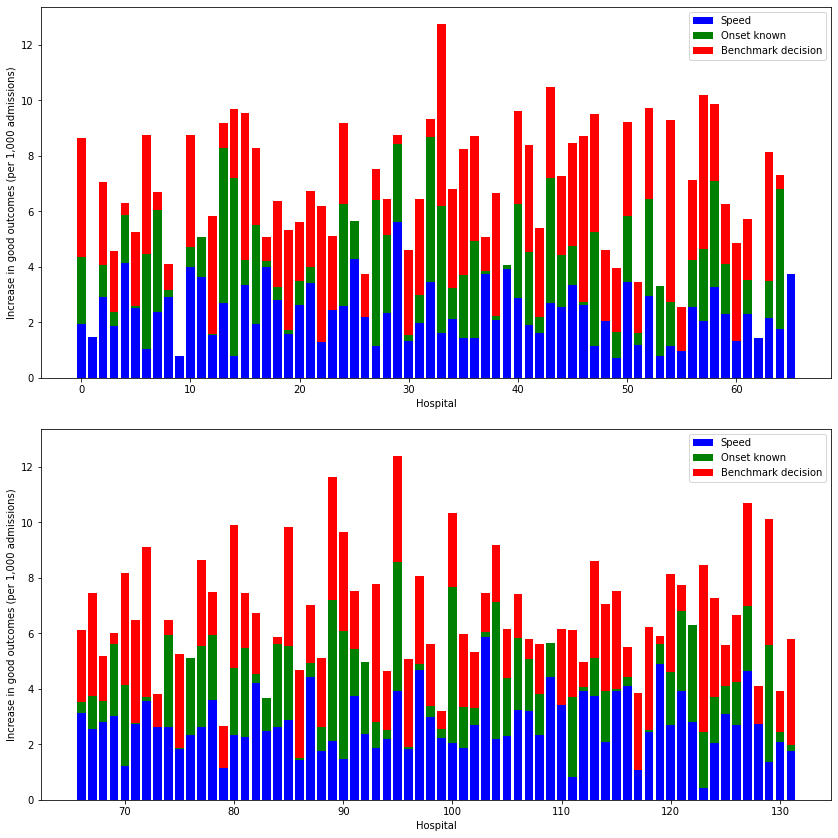

In [20]:
hosp_per_chart = np.ceil(results_pivot.shape[0]/2)

# Outcomes chart
fig, axs = plt.subplots(2,1, figsize=(12,12), sharey=True)
# 4 subplots
i=0
for ax in axs.flat:
    # Get subgroup of data for plot
    start = int(hosp_per_chart * i)
    end = int(hosp_per_chart * (i + 1))
    subgroup = results_pivot.iloc[start:end]
    
    # Get effect of speed (avoid negatives)
    speed = subgroup['additional_good_outcomes_per_1000_patients']['speed'] - \
        subgroup['additional_good_outcomes_per_1000_patients']['base']
    speed = list(map (lambda x: max(0,x), speed))
    # Get effect of known onset (avoid negatives)
    onset = subgroup['additional_good_outcomes_per_1000_patients']['onset'] - \
        subgroup['additional_good_outcomes_per_1000_patients']['base']
    onset = list(map (lambda x: max(0,x), onset))
    # Get effect of decision (avoid negatives)
    eligible = subgroup['additional_good_outcomes_per_1000_patients']['benchmark'] - \
        subgroup['additional_good_outcomes_per_1000_patients']['base']
    eligible = list(map (lambda x: max(0,x), eligible))
    
    x = range(start, start + subgroup.shape[0])
    ax.bar(x, speed, color='b', label = 'Speed')
    ax.bar(x, onset, color='g', bottom = speed, label = 'Onset known')
    ax.bar(x, eligible, color='r', bottom = np.array(speed) + np.array(onset),
           label = 'Benchmark decision')
    ax.legend()
    ax.set_xlabel('Hospital')
    ax.set_ylabel('Increase in good outcomes (per 1,000 admissions)')
    # Put y tick label son all charts
    ax.yaxis.set_tick_params(which='both', labelbottom=True)
    
    i += 1
      
plt.tight_layout(pad=2)
plt.savefig('./output/all_hosp_bar_outcomes.jpg', dpi=300)
plt.show()

## Results for individual hospitals

We may plot more detailed results at an individual hospital level.

In [28]:
def plot_hospital(data, id):
    
    hospital_data = data.iloc[id]
    
    max_val = max(hospital_data['thrombolysis_rate'].max(),
                  hospital_data['additional_good_outcomes_per_1000_patients'].max())
    
    max_val = 5 * int(max_val/5) + 5
    
    team = hospital_data.name
    
    # Sort results
    
    df = pd.DataFrame()
    df['thrombolysis_rate'] = hospital_data['thrombolysis_rate']
    df['outcomes'] = hospital_data['additional_good_outcomes_per_1000_patients']
    order = {'base': 1, 'speed': 2, 'onset': 3, 'benchmark': 4, 'speed_onset': 5,
    'speed_benchmark': 6, 'onset_benchmark':7, 'speed_onset_benchmark': 8,
    'same_patient_characteristics': 9}
    df_order = [order[x] for x in list(df.index)]
    df['order'] = df_order
    df.sort_values('order', inplace=True)
    
    df.drop('same_patient_characteristics', inplace=True)    

    fig = plt.figure(figsize=(10,7))

    ax1 = fig.add_subplot(121)
    x = df['thrombolysis_rate'].index
    y1 = df['thrombolysis_rate']
    ax1.bar(x,y1)
    plt.xticks(rotation=90)
    ax1.set_title('Thrombolysis use (%)')
    ax1.set_ylabel('Thrombolysis use (%)')
    ax1.set_ylim(0, max_val)
    ax1.grid(axis = 'y')

    ax2 = fig.add_subplot(122)
    y1 = df['outcomes']
    ax2.bar(x,y1, color='r')
    plt.xticks(rotation=90)
    ax2.set_title('Additional good outcomes\nper 1,000 admissions')
    ax2.set_ylabel('Additional good outcomes\nper 1,000 admissions')
    ax2.set_ylim(0, max_val)
    ax2.grid(axis = 'y')
    
    plt.suptitle(f'Scenario results for team: {team}')

    plt.tight_layout(pad=2)
    
    plt.savefig(f'./output/hosp_results_{team}.jpg', dpi=300)
    
    plt.show()

An example where speed makes most difference.

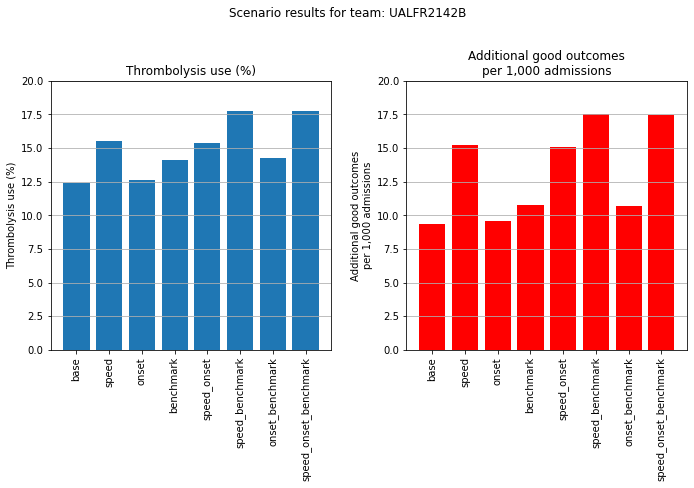

In [29]:
plot_hospital(results_pivot, 103)

An example where determining stroke onset time makes most difference.

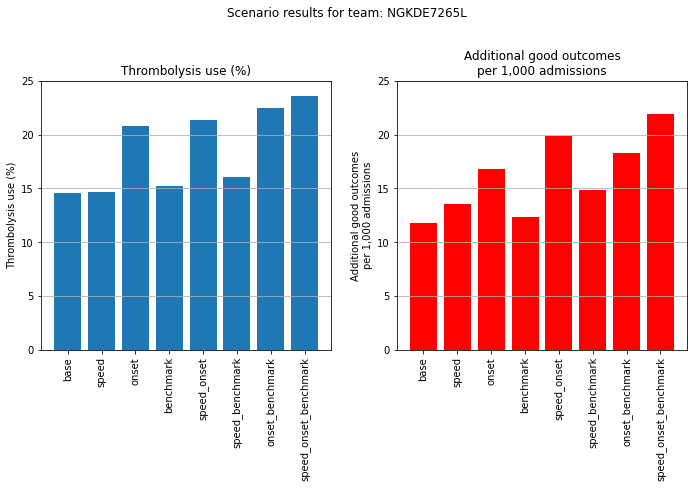

In [30]:
plot_hospital(results_pivot, 64)

An example where applying benchmark decion-making makes most difference.

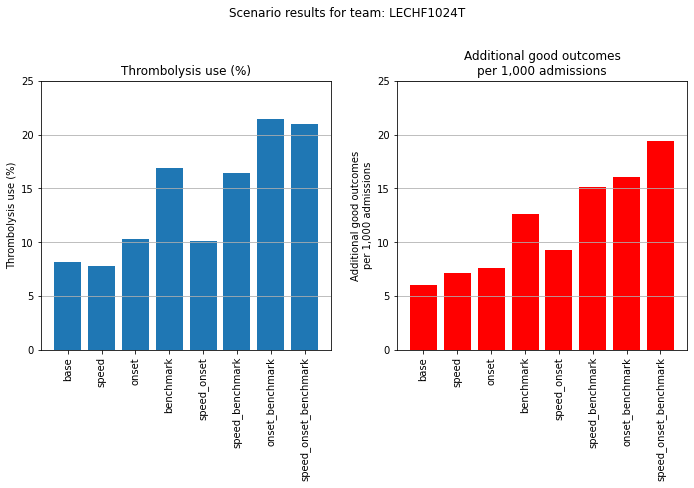

In [31]:
plot_hospital(results_pivot, 54)

## Observations

* The combined effect of the changes modelled were to increase thrombolysis use from 11.6% to 18.3% of all patients (57% increase), and to increase the number of thrombolysis-related good outcomes per 1,000 admissions from 9.4 to 17.6 (86% increase).

* Overall the net improvements made to thrombolysis use were benchmark decisions > determining stroke onset time > speed improvement.

* Overall the net improvements made to additional good outcomes  were speed improvement > benchmark decisions > determining stroke onset time.

* Speed improvement therefore had least effect on the proportion of patients receiving thrombolysis, but most effect on the the predicted outcomes. This is due to improving the speed of thrombolysis improving the outcomes for all patients, including those that would have received thrombolysis anyway (without speed improvement). 

* When asking the question "which single change makes most difference at each hospital?" then for thrombolysis the order is: benchmark decisions (82/132 hospitals), determining time of stroke onset (40/132), speed (10/132) and no-change (1/132). For improvements in clinical outcome the order is benchmark decisions (55/132 hospitals), speed (51/132), and determining time of stroke onset (26/132).

* Combining improvements to the pathway had a greater effect than any single change alone.

* Even with all improvements, there would still be expected to be a significant inter-hospital variation in use of thrombolysis and, the benefit gained. With the modelled improvements there is a general improvement across hospitals, and not a significant reduction in inter-hospital variation. The remaining variation is due to variation in patient populations.

* Charts may be readily produced for each hospitals showing the potential benefit of each process change individually or combined.